# LoRa Data Analysis - Upper Confidence Bound


We first declare a fixed parameters.

Those parameters are not changed during the experiments.

Fixed communication parameters are listed below:
- Code Rate: 4/5
- Frequency: 866.1 MHz
- Bandwidth: 125 kHz

End nodes:
- were sending different types of uplink messages.
- were sending a single message each 2 minutes.
- used an upper confidence bound algorithm (UCB) for communication parameters selection.

Access points:
- only a single access point was used
- capture effect was also considered

Initial declaration

In [75]:
%matplotlib inline
import pandas as pd # import pandas
import numpy as np # import numpy
import matplotlib.pyplot as plt # import plotting module
import statistics
import math
from IPython.display import set_matplotlib_formats # module for svg export

In [76]:
set_matplotlib_formats('svg') # set export to svg file
cut_ratio = 0.05 # Values below 5% of mean value are simply cut from charts to make it more readable

In [77]:
uplink_message_file = './18/uplink_messages.csv'

## Analysis of Uplink Messages

We read a csv file with uplink messages

In [78]:
uplink_data = pd.read_csv(uplink_message_file, delimiter=',')

Let us have a look at various columns that are present and can be evaluated.

In [79]:
uplink_data.head()

,id,app_data,snr,rssi,duty_cycle_remaining,is_primary,receive_time,seq,frequency,spf,power,airtime,coderate,bandwidth,msg_group_number,message_type_id,ap_id,node_id
0,102854,NzA3Ni44LDEzNTkuMQ==,2.5,-99.9,36000,t,2021-04-10 09:40:22.512,1,866100000,7,10,58,4/5,125000,124,1,111111,t3w0
1,102855,NTc4My4zLDQ5MDkuNw==,-17.4,-66.5,36000,t,2021-04-10 09:40:27.567,1,866100000,7,10,58,4/5,125000,111,2,111111,j6eI
2,102856,NzU4LjgsNjEzNS43,-12.6,-100.8,36000,t,2021-04-10 09:40:32.565,1,866100000,7,10,52,4/5,125000,155,2,111111,Qihc
3,102857,Njc2NC45LDMwNjAuMg==,-12.6,-90.5,36000,t,2021-04-10 09:40:38.065,1,866100000,7,10,58,4/5,125000,193,1,111111,iOK8
4,102858,OTExMy4xLDI4OTAuOA==,-17.6,-101.9,36000,t,2021-04-10 09:40:43.606,1,866100000,7,10,58,4/5,125000,252,1,111111,96VU


Remove all columns that have fixed values or there is no point in their analysis.

In [80]:
try:
    del uplink_data['id']
    del uplink_data['msg_group_number']
    del uplink_data['is_primary']
    del uplink_data['coderate']
    del uplink_data['bandwidth']
    del uplink_data['receive_time']
except KeyError:
    print('Columns have already been removed')

Let us have a look for different values to get an overview of overall values of different network parameters.

In [81]:
uplink_data.describe()

,snr,rssi,duty_cycle_remaining,seq,frequency,spf,power,airtime,message_type_id,ap_id
count,3881.000000,3881.000000,3881.0,3881.000000,3881.0,3881.000000,3881.000000,3881.000000,3881.000000,3881.0
mean,-6.982633,-94.392734,36000.0,6.534656,866100000.0,8.960835,12.231384,548.166967,1.982479,111111.0
std,9.789099,9.505589,0.0,4.125780,0.0,1.726092,1.986826,609.105457,0.131220,0.0
min,-19.900000,-109.300000,36000.0,1.000000,866100000.0,7.000000,10.000000,52.000000,1.000000,111111.0
25%,-15.100000,-100.800000,36000.0,3.000000,866100000.0,7.000000,10.000000,99.000000,2.000000,111111.0
50%,-10.000000,-96.900000,36000.0,6.000000,866100000.0,9.000000,14.000000,310.000000,2.000000,111111.0
75%,3.500000,-91.400000,36000.0,10.000000,866100000.0,10.000000,14.000000,594.000000,2.000000,111111.0
max,9.900000,-38.000000,36000.0,20.000000,866100000.0,12.000000,14.000000,2343.000000,2.000000,111111.0


Create a new column 'arm'. This columns represents a combination of SF and TP and is referred in multi-armed bandit terminology as arm.

In [82]:
uplink_data['arm'] = 'S' + uplink_data.spf.astype(str) + 'P' + uplink_data.power.astype(str)

### Communication parameters selection

In [83]:
arms = uplink_data.arm.value_counts()
threshold = round(statistics.mean(uplink_data.arm.value_counts()) * cut_ratio, 2)
print(f'Values below {threshold} will be cut from a plot')
arms = arms[arms > threshold]

Values below 16.17 will be cut from a plot


Text(0, 0.5, 'Number of Messages')

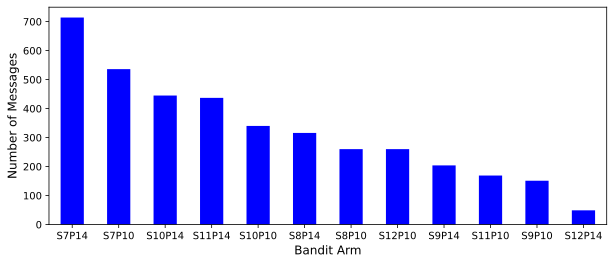

In [84]:
# set_matplotlib_formats('svg')
hist = arms.plot(kind='bar',rot=0, color='b',figsize=(10,4))
hist.set_xlabel("Bandit Arm",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

Export plot to SVG.

In [85]:
hist.get_figure().savefig('ucb-bandit-arms.svg')

### Duty cycle values

In [86]:
uplink_data.duty_cycle_remaining.describe()

count     3881.0
mean     36000.0
std          0.0
min      36000.0
25%      36000.0
50%      36000.0
75%      36000.0
max      36000.0
Name: duty_cycle_remaining, dtype: float64

### Spreading Factor

Text(0, 0.5, 'Number of Messages')

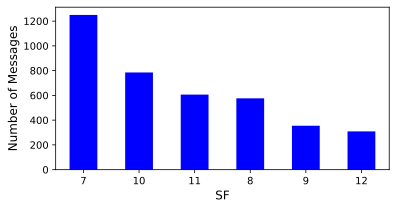

In [87]:
hist = uplink_data.spf.value_counts().plot(kind='bar',rot=0,color='b',figsize=(6,3))
hist.set_xlabel("SF",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

### Utilization of Frequency

Frequency is stored in Hz, so we need to convert it to MHz.

In [88]:
uplink_frequency = uplink_data.frequency / 1000000

Text(0, 0.5, 'Number of Messages')

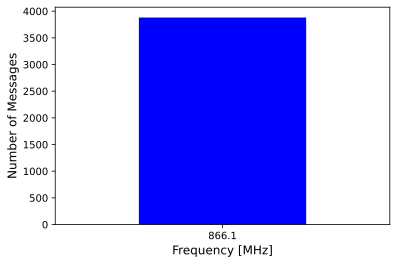

In [89]:
hist = uplink_frequency.value_counts().plot(kind='bar',rot=0,color='b')
hist.set_xlabel("Frequency [MHz]",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

All nodes used the same frequency to increase a probability of collisions.

# Utilization of different Access Points

Text(0, 0.5, 'Number of Messages')

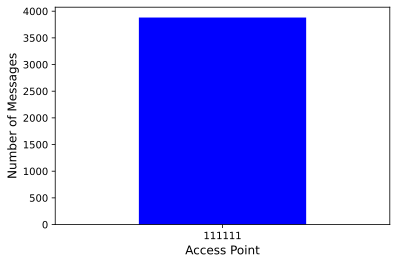

In [90]:
hist = uplink_data.ap_id.value_counts().plot(kind='bar',rot=0,color='b')
hist.set_xlabel('Access Point',fontsize=12)
hist.set_ylabel('Number of Messages',fontsize=12)

We have only a single Access Point.

### Duration of Data Transmission

In [91]:
airtime = uplink_data.airtime.value_counts()
threshold = 100
airtime = airtime.loc[lambda x : x > threshold]
print(f'Values with low then {threshold} occurences will be cut from a plot')

Values with low then 100 occurences will be cut from a plot


Text(0, 0.5, 'Number of Messages')

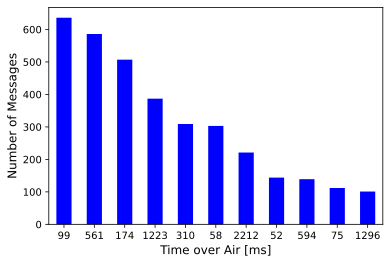

In [92]:
hist = airtime.plot(kind="bar",rot=0,color='b')
hist.set_xlabel("Time over Air [ms]",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

In [93]:
hist.get_figure().savefig('ucb-airtime.svg')

### Transmission Power

Only two transmission power values were possible in this scenario.

To increase TP a value of 14 was used, to decrease TP a value of 10 was used.

Text(0, 0.5, 'Number of Messages')

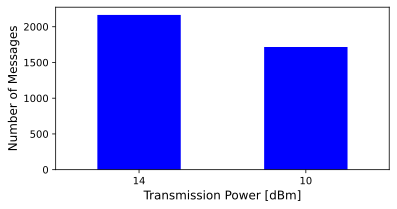

In [94]:
hist = uplink_data.power.value_counts().plot(kind="bar",rot=0,color='b',figsize=(6,3))
hist.set_xlabel("Transmission Power [dBm]",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)

### Analysis of End Nodes

In [95]:
print(f'Number of end nodes partiipating in the experiment is {uplink_data.node_id.nunique()}.')

Number of end nodes partiipating in the experiment is 88.


In [96]:
uplink_data.node_id.describe()

count     3881
unique      88
top       WtAl
freq        77
Name: node_id, dtype: object

In [97]:
unique_ens = len(uplink_data.node_id.unique())
unique_aps = len(uplink_data.ap_id.unique())

In [98]:
print(f'Total number of connected end devices: {unique_ens}')
print(f'Total number of connected access points: {unique_aps}')

Total number of connected end devices: 88
Total number of connected access points: 1


## End Nodes

Analysis of certain aspects (active time, sleep time and collisions) of end devices.

In [99]:
end_nodes = pd.read_csv('./18/ucb - experiment - 18 - 1.csv', delimiter=',')

In [100]:
end_nodes.head()

,dev_id,active_time,uptime,collisions
0,nn66,0.16,24.28,2
1,jLn5,1.16,24.29,1
2,Hh7f,0.00,24.28,1
3,VGHy,0.21,24.31,2
4,xhil,0.16,24.33,4


### Collision histogram

Cutting values is disabled.

In [101]:
no_collisions = end_nodes.collisions.value_counts()
threshold = statistics.mean(end_nodes.collisions.value_counts())
print(f'Values below {threshold} will be cut in a plot')

Values below 6.6 will be cut in a plot


In [102]:
collisions = end_nodes.collisions[end_nodes.collisions > threshold]
collisions.describe()

count    29.000000
mean      9.517241
std       3.066183
min       7.000000
25%       7.000000
50%       9.000000
75%      11.000000
max      22.000000
Name: collisions, dtype: float64

In [103]:
max_collisions = max(collisions)
min_collisions = min(collisions)
range_collisions = max_collisions - min_collisions
increment = math.ceil(range_collisions / 4)

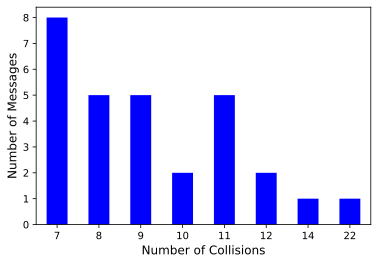

In [104]:
# out = pd.cut(collisions, bins=[min_collisions, min_collisions + increment, min_collisions + 2 * increment, min_collisions + 3 * increment, max(collisions)], include_lowest=True)
hist = collisions.value_counts(sort=False).plot.bar(rot=0,color='b')
hist.set_xlabel("Number of Collisions",fontsize=12)
hist.set_ylabel("Number of Messages",fontsize=12)
plt.show()

In [105]:
hist.get_figure().savefig('ucb-collisions.svg')

### Ration between active time and total nodes uptime

In [106]:
energy = (end_nodes.active_time / end_nodes.uptime)

In [107]:
energy.describe()

count    99.000000
mean      0.024966
std       0.033963
min       0.000000
25%       0.002008
50%       0.010497
75%       0.041973
max       0.193291
dtype: float64

In [109]:
active_time = round(statistics.mean(energy) * 100, 2)
print(f'The nodes spent {active_time}% of their uptime in active mode.')

The nodes spent 2.5% of their uptime in active mode.
